In [1]:
import os

os.environ["backend"] = "numpy"
from psfit.optim import ProjectionSparsifier


from psfit.data import MNIST, ImageNormalizer
import matplotlib.pyplot as plt

from psfit.model import SparseSoftmaxClassifier

### Dataset Loading and Classifier Initialization

In this section, we will load the MNIST dataset and initialize a classifier to train on this data. The MNIST dataset contains images of handwritten digits and is commonly used for evaluating machine learning algorithms.

1. **Dataset Loading**:
   - We specify the path to the MNIST dataset file and create an instance of the `MNIST` class. The dataset is preprocessed using `ImageNormalizer`, which will normalize the pixel values of the images for better training performance. The `cv` parameter indicates that we will perform cross-validation during the training process.

2. **Classifier Initialization**:
   - We initialize the `SparseSoftmaxClassifier`, providing the following parameters:
     - `dataset`: The dataset we just loaded.
     - `batch_size`: This parameter specifies the number of samples to be processed in each batch during training.
     - `learning_rate`: The rate at which the model updates its weights during training.
     - `penalty`: This parameter controls regularization, which helps prevent overfitting by discouraging overly complex models.
     - `local_epochs`: The number of epochs to run on local data for each round of training.
     - `admm_iterations`: The number of iterations for the Alternating Direction Method of Multipliers (ADMM) optimization.
     - `validation_accuracy` and `training_accuracy`: These parameters indicate whether to compute accuracy metrics during training and validation phases.
     - `verbose`: When set to `True`, this parameter enables detailed logging of the training process for better insights.

The following code implements the dataset loading and classifier setup:


In [2]:
datapath = "../../../data/mnist-data.npz"
dataset = MNIST(filename = datapath, preprocessor = ImageNormalizer(), cv = True)

iters = 100

classifier = SparseSoftmaxClassifier(
    dataset = dataset,
    batch_size = 47000,
    learning_rate = 0.9,
    penalty = 0.1,
    local_epochs = 1,
    admm_iterations = iters,
    validation_accuracy = True,
    training_accuracy = True,
    verbose = False
)

Loading batches to cpu

Number of batches loaded: 1


### Model Training and Error Tracking

In this section, we will train the `SparseSoftmaxClassifier` on the MNIST dataset and track the training loss and primal error values throughout the training process.

1. **Model Training**:
   - We call the `fit` method of the `classifier`, which initiates the training process. This method takes a `sparsifier` parameter, which in this case is set to `ProjectionSparsifier` with a specified `density`. This sparsifier helps to enforce sparsity in the model's updates, potentially improving efficiency and performance.

2. **Output Values**:
   - The `fit` method returns two key outputs:
     - `training_loss_values`: A list of loss values recorded during the training process, which can be used to evaluate how well the model is learning.
     - `primal_error_values`: A list of primal error values, providing insights into the model's accuracy and performance during training.

The following code implements the training process and captures the relevant metrics:


In [3]:
training_loss_values, primal_error_values = classifier.fit(sparsifier = ProjectionSparsifier(density = 250))

In [4]:
import numpy as np
np.linalg.norm(classifier.params.array(),2)


np.float32(3.1419013)

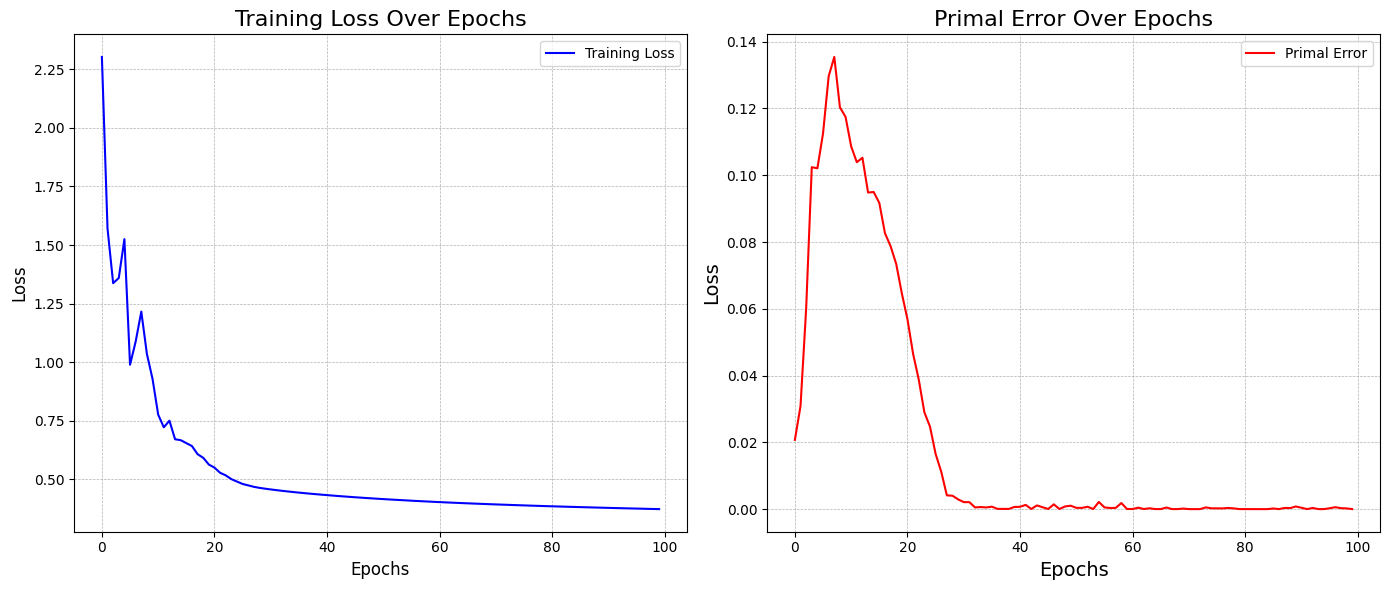

In [5]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
epochs = list(range(iters))
# Training Loss Plot
ax1.plot(epochs, training_loss_values, linestyle = '-', color = 'b', label = 'Training Loss')
ax1.set_title('Training Loss Over Epochs', fontsize = 16)
ax1.set_xlabel('Epochs', fontsize = 12)
ax1.set_ylabel('Loss', fontsize = 12)
ax1.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
ax1.legend()

# Primal Error Plot
ax2.plot(epochs, primal_error_values, linestyle = '-', color = 'r', label = 'Primal Error')
ax2.set_title('Primal Error Over Epochs', fontsize = 16)
ax2.set_xlabel('Epochs', fontsize = 12)
ax2.set_ylabel('Error', fontsize = 12)
ax2.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
ax2.legend()

plt.xlabel('Epochs', fontsize = 14)  # X-axis label
plt.ylabel('Loss', fontsize = 14)  # Y-axis label

# Add a grid for better readability
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()


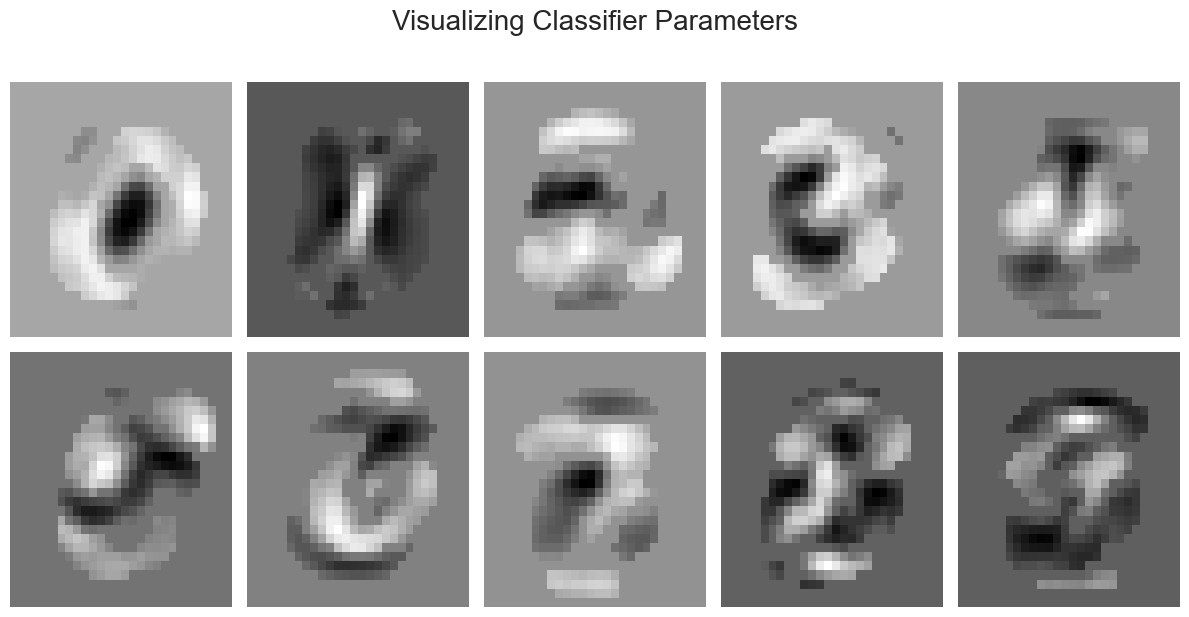

In [6]:
import matplotlib.pyplot as plt

# Image size and grid setup
img_size = (28, 28)
cols, rows = 2, 5

# Create a figure with subplots
fig, axes = plt.subplots(cols, rows, figsize = (12, 6))

# Variable k to index through images
k = 0

# Loop over each subplot and add images
for i in range(cols):
    for j in range(rows):
        # Plot the image on the axes
        axes[i, j].imshow(classifier.params[:, k].array().reshape(img_size), cmap = 'gray', aspect = 'auto')
        axes[i, j].axis('off')  # Turn off the axis labels for cleaner visuals
        k += 1

# Add an overall title
fig.suptitle('Visualizing Classifier Parameters', fontsize = 20, y = 1.02)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top = 0.9)  # Leave space for the main title

# Show the figure
plt.show()


In [11]:
X, y = dataset.train_data
X_cv, y_cv = dataset.cv_data

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from psfit import tensor

# Convert data X to tensor
x_train = tensor(X)
x_cv = tensor(X_cv)
# Make predictions on the training data
y_pred_training = classifier.predict(x_train)
y_pred_cv = classifier.predict(x_cv)
# Calculate training accuracy
training_acc = accuracy_score(y_pred_training, y)
cv_acc = accuracy_score(y_pred_cv, y_cv)
print(f"Training Accuracy: {training_acc:.5f}")
print(f"Cross-Validation Accuracy: {cv_acc:.5f}")


Training Accuracy: 0.79619
Cross-Validation Accuracy: 0.79925


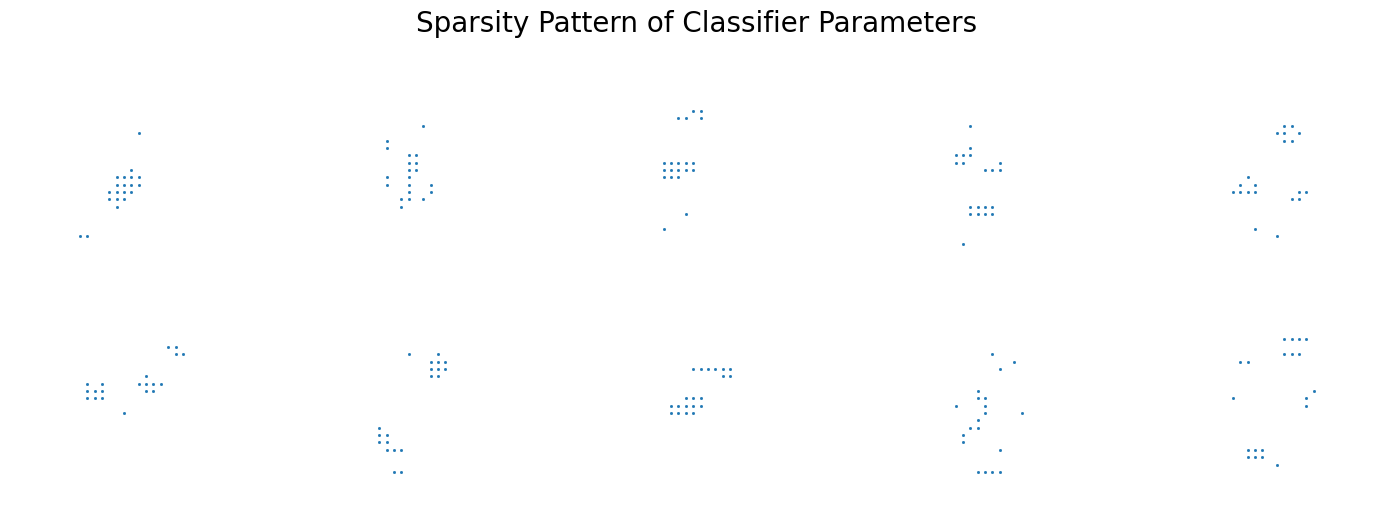

In [13]:
import matplotlib.pyplot as plt

# Number of columns, rows, and image size
cols, rows = 2, 5
fig, axes = plt.subplots(cols, rows, figsize = (15, 5))

# Variable k to index through the classifier parameters
k = 0

# Loop over each subplot and add the spy plots
for i in range(cols):
    for j in range(rows):
        # Plot the sparsity pattern of the parameters
        axes[i, j].spy(classifier.params[:, k].array().cpu().reshape(img_size), markersize = 1)
        axes[i, j].axis('off')  # Turn off axis ticks for a cleaner look
        k += 1

# Add an overall title
fig.suptitle('Sparsity Pattern of Classifier Parameters', fontsize = 20, y = 1.02)

# Adjust the layout to fit everything nicely
plt.tight_layout()
# plt.subplots_adjust(top=0.85)  # Leave space for the main title

# Show the plot
plt.show()
